val :  (3322, 81, 81, 3) 0/1 split 50.0 %
train :  (20474, 81, 81, 3) 0/1 split 50.0 %


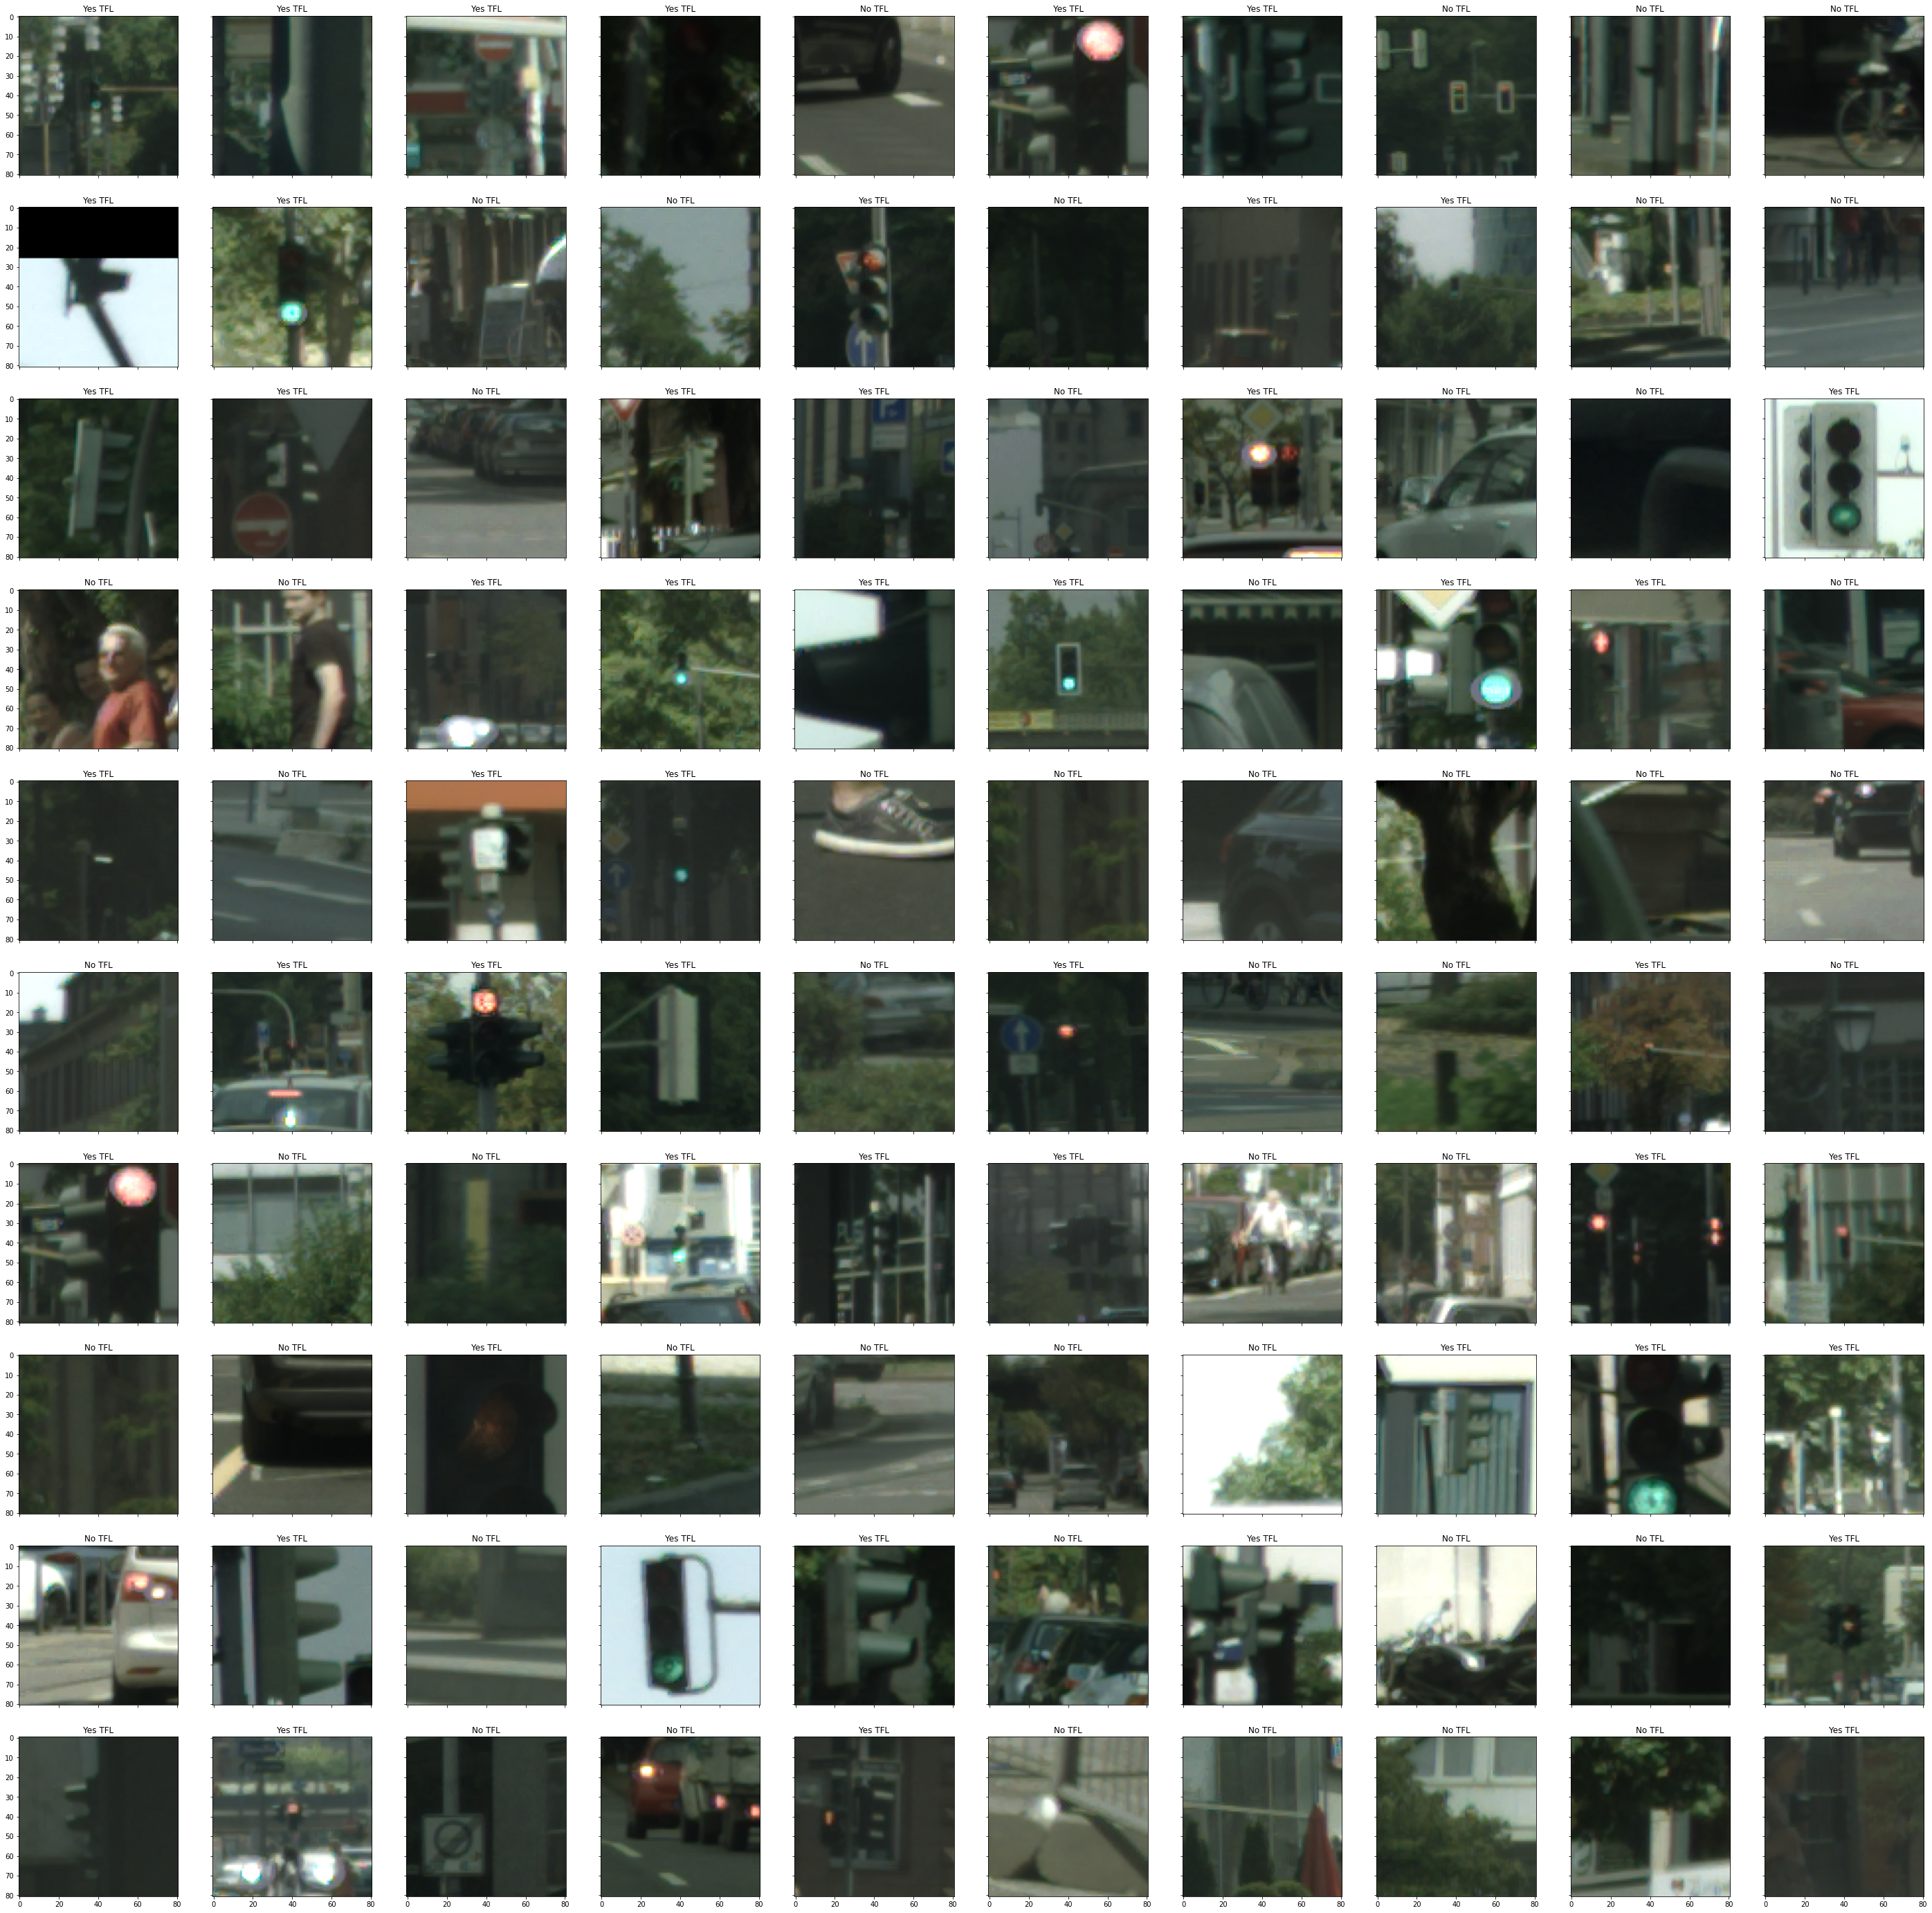

In [1]:
  
import os

import numpy as np
from PIL import Image
import json

import matplotlib.pyplot as plt
from os.path import join


def read_file(filename):
    with open(filename) as img_data:
        labels = json.load(img_data)['objects']
        return labels


def find_center(polygon):
    return [x_center(polygon), y_center(polygon)]


def x_center(polygon):
    min_x = min(list(map(lambda p: p[0], polygon)))
    max_x = max(list(map(lambda p: p[0], polygon)))
    return min_x + (max_x - min_x) // 2


def y_center(polygon):
    min_y = min(list(map(lambda p: p[1], polygon)))
    max_y = max(list(map(lambda p: p[1], polygon)))
    return min_y + (max_y - min_y) // 2


def classify_pixels(labels):
    traffic_lights = list(filter(lambda label: label['label'] == 'traffic light', labels))
    traffic_lights = list(map(lambda t: t['polygon'], traffic_lights))
    traffic_lights = list(map(find_center, traffic_lights))
    non_traffic_lights = n_random_pixels(labels, len(trafflabel['label']ic_lights))
    # print(len(non_traffic_lights))
    # print(len(traffic_lights))
    return traffic_lights, non_traffic_lights


def n_random_pixels(labels, n):
    random_labels = list(filter(lambda label:  != 'traffic light', labels))
    all_random_pixels = np.concatenate([l['polygon'] for l in random_labels])
    random_indices = np.random.choice(len(all_random_pixels), n, replace=False)
    return all_random_pixels[random_indices]


def deal_with_edge_cases(center_index, image, size=81):
    half_size = size // 2
    zeros_array = np.zeros((size, size, 3))
    difference_x = half_size - (center_index[0])
    difference_y = half_size - (center_index[1])
    for i in range(len(image)):
        for j in range(len(image[0])):
            zeros_array[i + difference_x][j + difference_y] = image[i][j]
    return zeros_array


def crop_image(img, tfl_pixels, not_tfl_pixels):
    images = []
    # tfl_pixels.append([2000, 1000])
    # not_tfl_pixels.append([0, 0])
    labels = [1] * len(tfl_pixels) + [0] * len(not_tfl_pixels)

    im = np.asarray(Image.open(img))

    for pixel in tfl_pixels + list(not_tfl_pixels):
        left = max(0, pixel[0] - 40)
        right = min(2048, pixel[0] + 40)
        top = max(0, pixel[1] - 40)
        bottom = min(1024, pixel[1] + 40)
        # print(pixel, left, right, top, bottom)
        cropped = im[top:bottom + 1, left:right + 1, :]
        # print(cropped.shape)

        # .crop((left, top, right, bottom))

        width, height = cropped.shape[:2]
        if width < 81 or height < 81:
            new_pixel = (pixel[0] - left, pixel[1] - top)
            # print("ggg")

            cropped = deal_with_edge_cases(new_pixel[::-1], cropped)
        images.append(cropped)
        # print(len(images))
        # plt.imshow(cropped)
        # plt.show()
    return images, labels


def convert_to_bin(image, img_name):
    image = np.asarray(image, dtype=np.uint8)
    # print(len(image))
    with open(f'{img_name}.bin', 'ab') as labels_bin:
        for im in image:
            try:
                labels_bin.write(im.tobytes())
            except:
                labels_bin.write(im.to_bytes(1, "little"))


def create_bin_files(images, labels, path):
    try:
        os.makedirs(path)
    except FileExistsError:
        pass
    convert_to_bin(images, f"{path}/data")
    convert_to_bin(labels, f"{path}/labels")


def create_data_set():
    counter = 0
    for r, d, f in os.walk('./gtFine/val'):
        for file in f:
            if file.endswith(".json"):
                img = f'./leftImg8bit/val/{file.split("_")[0]}/' + file[:-20] + 'leftImg8bit.png'
                tfl_pixels, not_tfl_pixels = classify_pixels(read_file(f'./gtFine/val/{file.split("_")[0]}/' + file))
                counter += (len(tfl_pixels) + len(not_tfl_pixels))
                create_bin_files(*crop_image(img, tfl_pixels, not_tfl_pixels), "Data_dir/val")
    print('images in val: {}'.format(counter))

    for r, d, f in os.walk('./gtFine/train'):
        for file in f:
            if file.endswith(".json"):
                img = f'./leftImg8bit/train/{file.split("_")[0]}/' + file[:-20] + 'leftImg8bit.png'
                tfl_pixels, not_tfl_pixels = classify_pixels(read_file(f'./gtFine/train/{file.split("_")[0]}/' + file))
                counter += (len(tfl_pixels) + len(not_tfl_pixels))
                create_bin_files(*crop_image(img, tfl_pixels, not_tfl_pixels), "Data_dir/train")
    print('images in train: {}'.format(counter))

# create_data_set()


def load_tfl_data(data_dir, crop_shape=(81, 81)):
    images = np.memmap(join(data_dir, 'data.bin'), mode='r', dtype=np.uint8).reshape([-1] + list(crop_shape) + [3])
    labels = np.memmap(join(data_dir, 'labels.bin'), mode='r', dtype=np.uint8)
    return {'images': images, 'labels': labels}


def viz_my_data(images, labels, predictions=None, num=(5, 5), labels2name={0: 'No TFL', 1: 'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0] * num[1]
    ax = plt.subplots(num[0], num[1], figsize=(h * num[0], h * num[1]), gridspec_kw={'wspace': 0.05}, squeeze=False,
                      sharex=True, sharey=True)[1]  # .flatten()
    idxs = np.random.randint(0, images.shape[0], n)
    for i, idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None: title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
    plt.show()


# root = './'  #this is the root for your val and train datasets
data_dir = './Data_dir/'
datasets = {
    'val': load_tfl_data(join(data_dir, 'val')),
    'train': load_tfl_data(join(data_dir, 'train')),
}
for k, v in datasets.items():
    print('{} :  {} 0/1 split {:.1f} %'.format(k, v['images'].shape, np.mean(v['labels'] == 1) * 100))

viz_my_data(num=(10, 10), **datasets['val'])

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 79, 79, 32)        864       
_________________________________________________________________
batch_normalization_60 (Batc (None, 79, 79, 32)        128       
_________________________________________________________________
activation_60 (Activation)   (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 77, 77, 32)        9216      
_________________________________________________________________
batch_normalization_61 (Batc (None, 77, 77, 32)        128       
_________________________________________________________________
activation_61 (Activation)   (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 38, 38, 32)       

In [23]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
data_dir = './Data_dir/'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
#prepare our model
m = tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 7,batch_size = 25)

Epoch 1/7
819/819 [==============================] - 618s 749ms/step - loss: 0.4582 - accuracy: 0.7758 - val_loss: 0.5587 - val_accuracy: 0.7559
Epoch 2/7
819/819 [==============================] - 625s 763ms/step - loss: 0.3358 - accuracy: 0.8529 - val_loss: 0.3176 - val_accuracy: 0.8525
Epoch 3/7
819/819 [==============================] - 728s 889ms/step - loss: 0.2823 - accuracy: 0.8813 - val_loss: 0.2959 - val_accuracy: 0.8700
Epoch 4/7
819/819 [==============================] - 806s 985ms/step - loss: 0.2423 - accuracy: 0.9002 - val_loss: 0.3108 - val_accuracy: 0.8621
Epoch 5/7
819/819 [==============================] - 817s 998ms/step - loss: 0.2088 - accuracy: 0.9151 - val_loss: 0.2629 - val_accuracy: 0.8889
Epoch 6/7
819/819 [==============================] - 831s 1s/step - loss: 0.1809 - accuracy: 0.9288 - val_loss: 0.3169 - val_accuracy: 0.8682
Epoch 7/7
819/819 [==============================] - 807s 986ms/step - loss: 0.1589 - accuracy: 0.9390 - val_loss: 0.3028 - val_accur

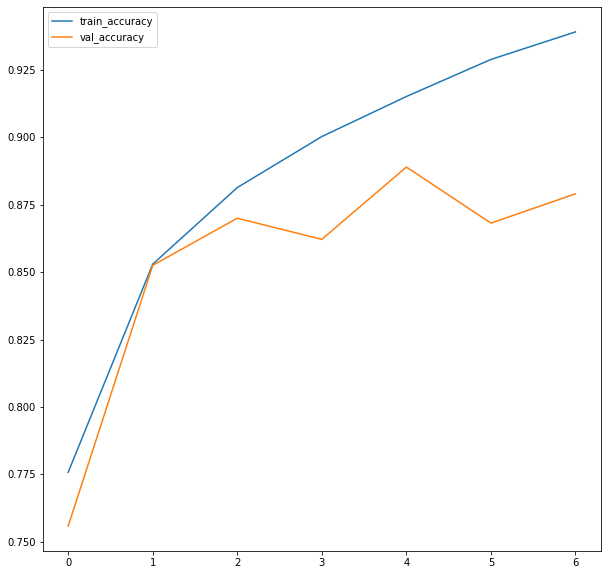

In [24]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_accuracy'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_accuracy','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

c:\users\chava neiman\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


accuracy: 0.8789885611077664


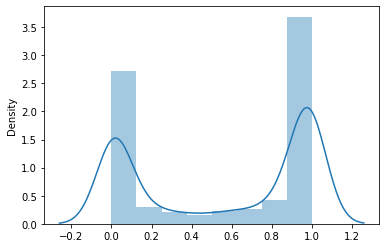

In [26]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

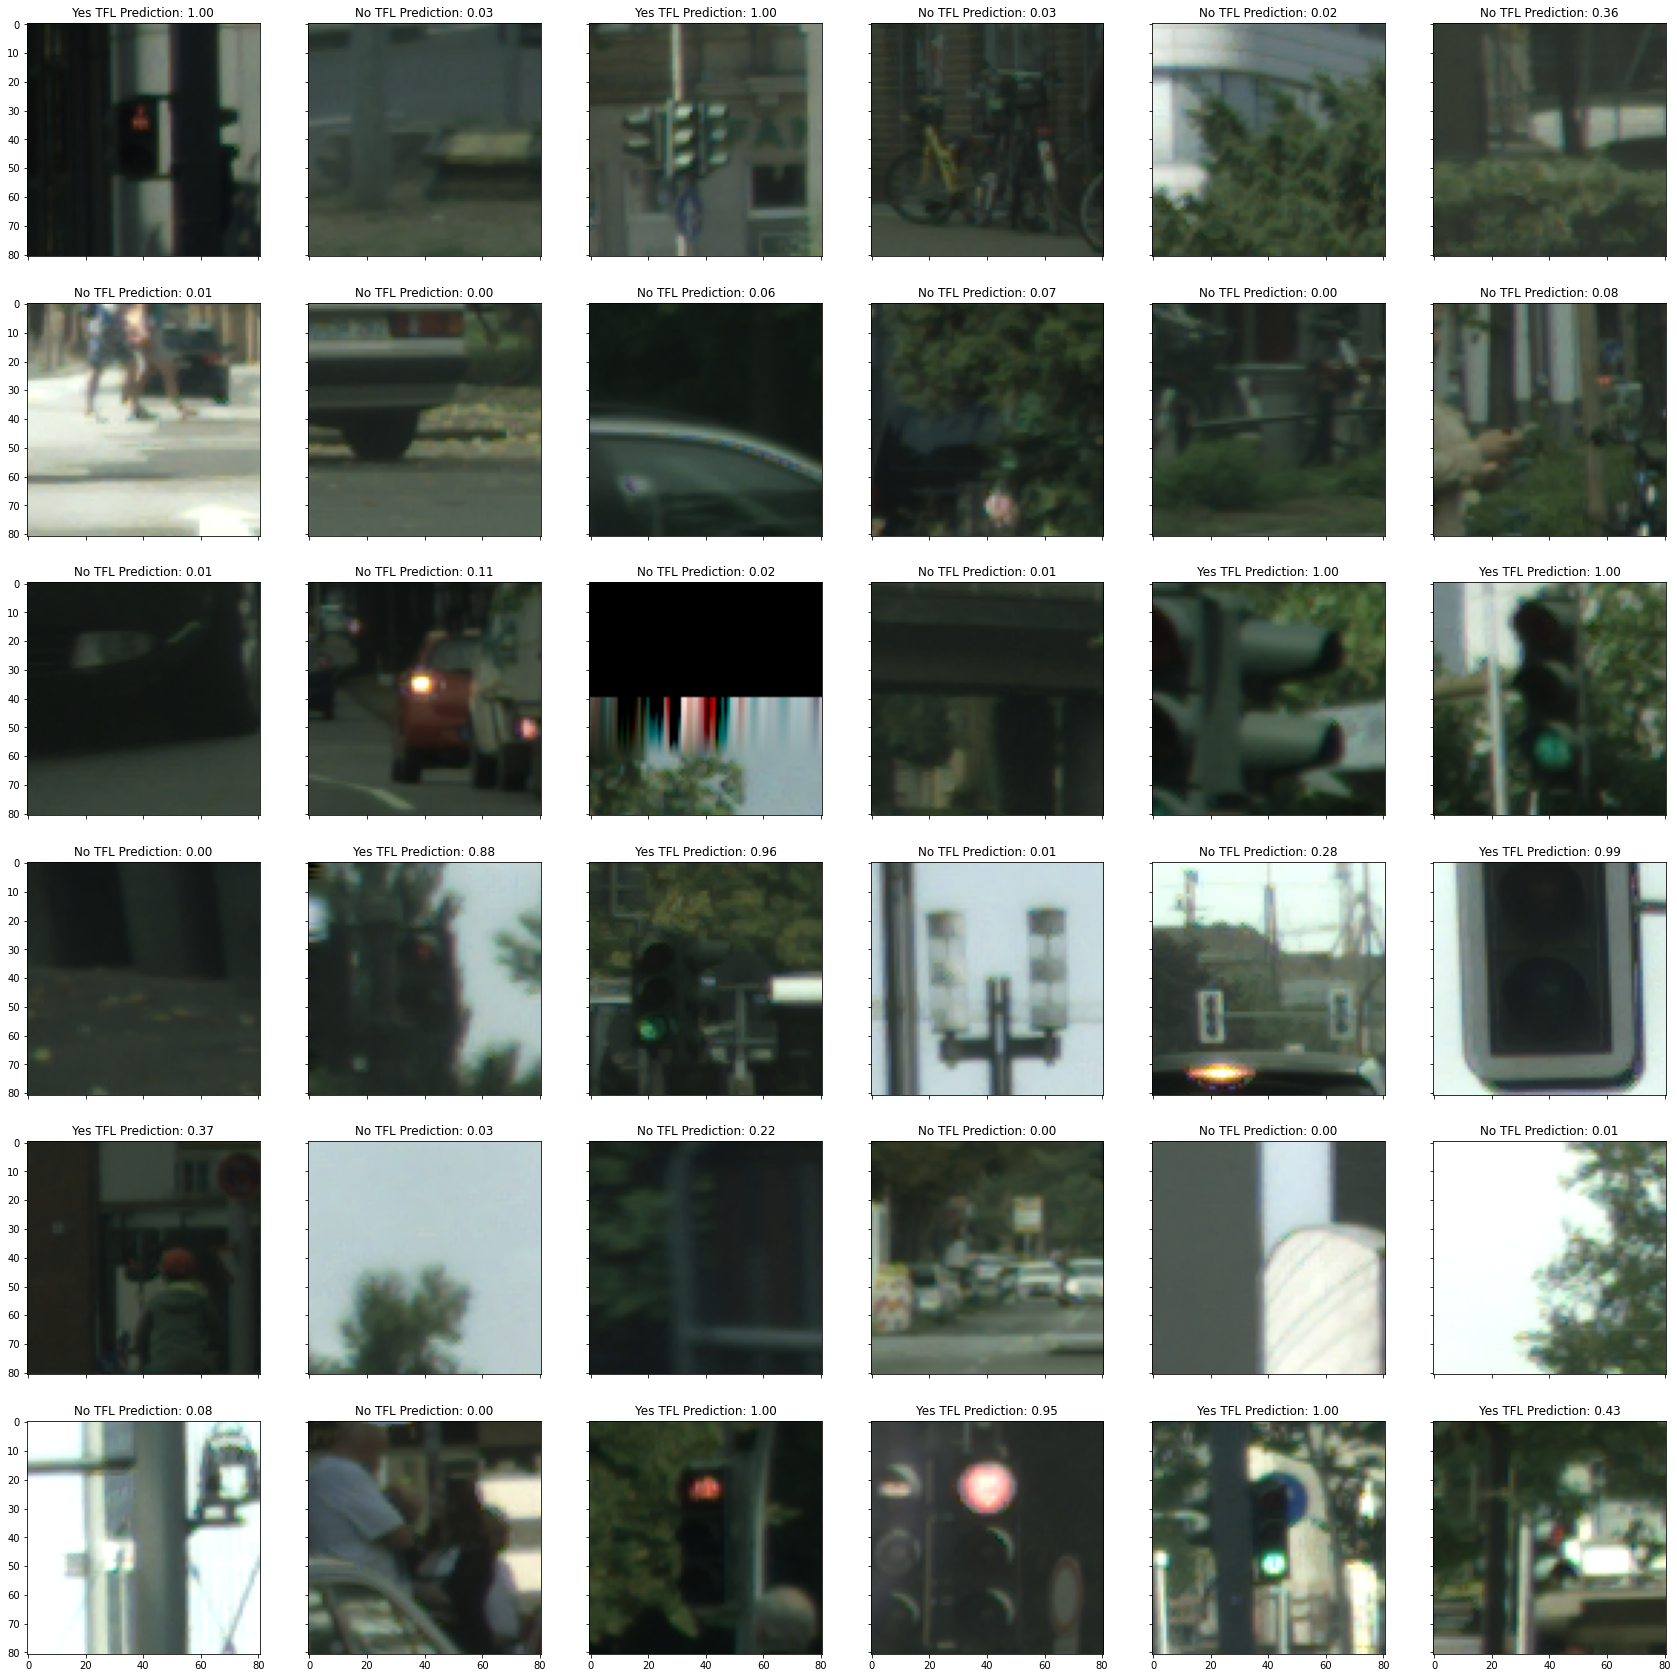

In [27]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

In [16]:
m.save("model.h5")

In [17]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h5")

c:\users\chava neiman\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


accuracy: 0.8431667670078266


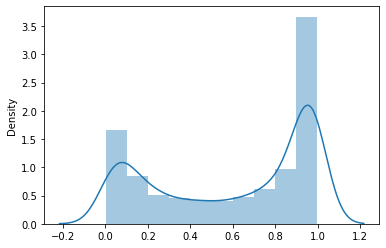

In [18]:
# code copied from the training evaluation: 
l_predictions = loaded_model.predict(val['images'])
sbn.distplot(l_predictions[:,0]);

l_predicted_label = np.argmax(l_predictions, axis=-1)
print ('accuracy:', np.mean(l_predicted_label==val['labels']))